## Imports

In [5]:
import pickle

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Model Analysis: SARIMA

## Forecast by number of orders

In [7]:
df_order = pd.read_csv('Dataset/daily_coffee_count.csv')
df_order.head(5)

,date,order_count
0,2024-03-01,11
1,2024-03-02,7
2,2024-03-03,10
3,2024-03-04,4
4,2024-03-05,9


In [8]:
df_order['date'] = pd.to_datetime(df_order['date'])
df_order = df_order.sort_values('date')

In [9]:
df_order_21 = df_order.tail(21).set_index('date')
df_order_30 = df_order.tail(30).set_index('date')
df_order_60 = df_order.tail(60).set_index('date')
df_order_90 = df_order.tail(90).set_index('date')

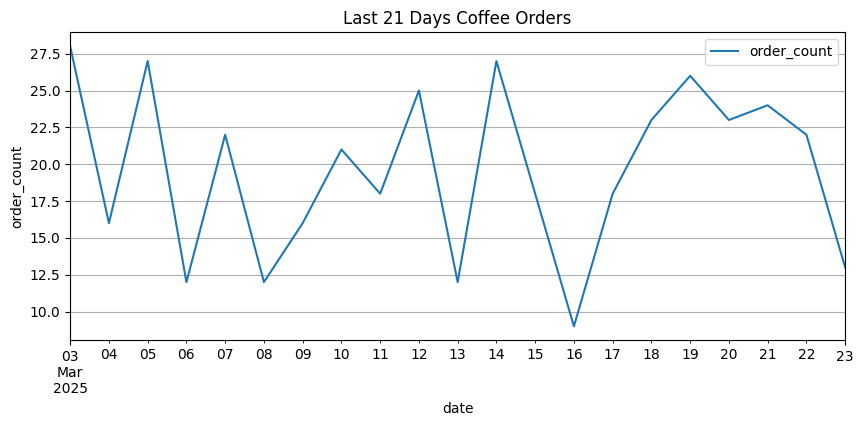

In [10]:
df_order_21.plot(title='Last 21 Days Coffee Orders', figsize=(10, 4))
plt.ylabel('order_count')
plt.grid()
plt.show()

In [11]:
result = adfuller(df_order_21.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

if result[1] <= 0.05:
    print("Series is stationary")
else:
    print("Series is not stationary")

ADF Statistic: -5.6815556910570635
p-value: 8.463298204751647e-07
Critical Values:
	1%: -3.8092091249999998
	5%: -3.0216450000000004
	10%: -2.6507125
Series is stationary


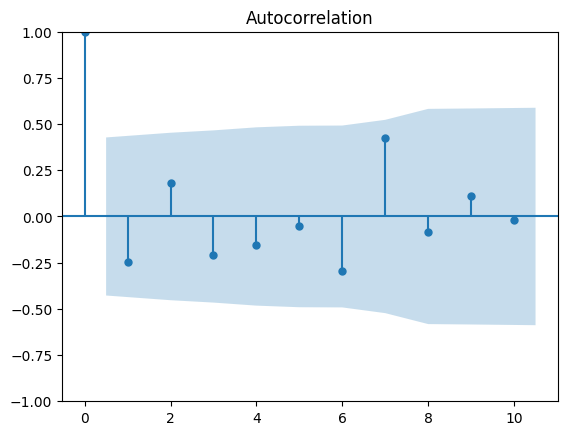

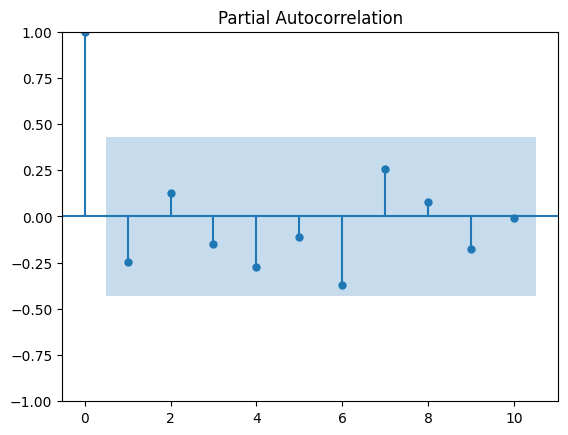

In [12]:
plot_acf(df_order_21)
plot_pacf(df_order_21)
plt.show()

<Axes: title={'center': '7-Day Rolling Mean'}, xlabel='date'>

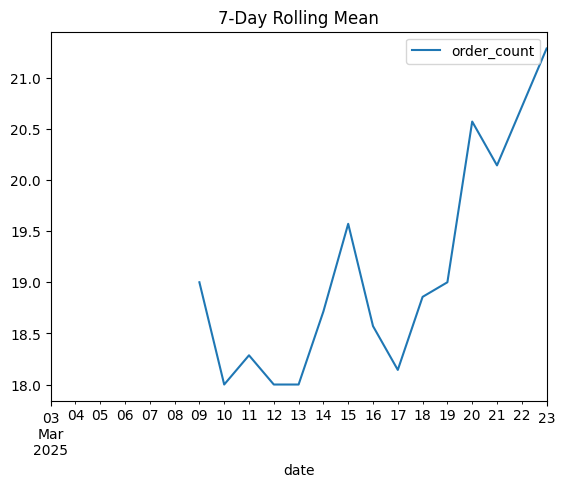

In [13]:
df_order_21.rolling(window=7).mean().plot(title="7-Day Rolling Mean")

In [14]:
sarima_model = auto_arima(df_order_21,
                          seasonal=True,
                          m=7,  # 7-day seasonality
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

print("Best model:", sarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=136.280, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=133.220, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=188.278, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=136.757, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=133.039, Time=0.11 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=131.075, Time=0.10 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=131.766, Time=0.04 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=133.075, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(2,0,0)[7] intercept   : AIC=133.042, Time=0.11 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=134.984, Time=0.18 sec
 A

In [15]:
with open("sarima_model_orders.pkl", "wb") as f:
    pickle.dump(sarima_model, f)

In [10]:
n_days = 7  # forecast 7 days
forecast = sarima_model.predict(n_periods=n_days)

last_date = df_order_21.index[-1]
forecast_index = [last_date + pd.Timedelta(days=i) for i in range(1, n_days+1)]
forecast_series = pd.Series(forecast, index=pd.to_datetime(forecast_index))

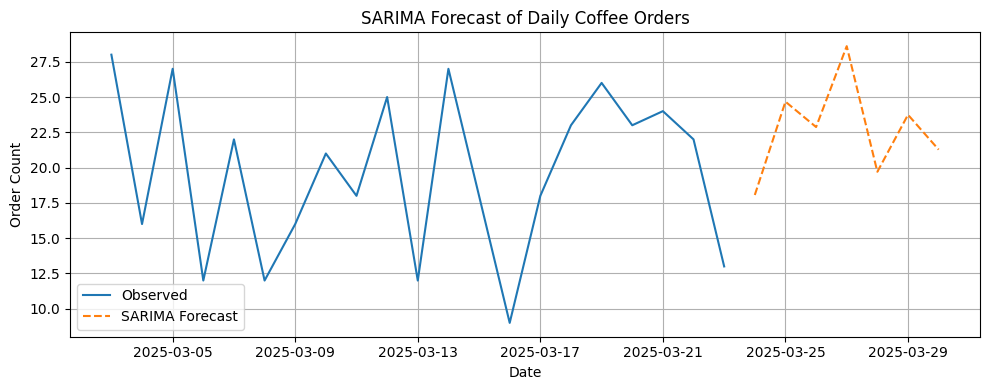

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(df_order_21.index, df_order_21, label='Observed')
plt.plot(forecast_series.index, forecast_series, label='SARIMA Forecast', linestyle='--')
plt.title('SARIMA Forecast of Daily Coffee Orders')
plt.ylabel('Order Count')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Evaluate

In [16]:
train = df_order_21[:-7]
test = df_order_21[-7:]
train = train['order_count']
test = test['order_count']

In [17]:
sarima_model = auto_arima(train,
                          seasonal=True,
                          m=7,
                          D=0,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=94.454, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=90.884, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=125.269, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=91.703, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=91.402, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=92.445, Time=0.12 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=91.831, Time=0.04 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=94.691, Time=0.19 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=92.083, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=93.065, Time=0.10 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=89.652, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=93.683, Time=0.06 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=93.562, Time=0.17 sec
 A

In [ ]:
with open("sarima_model_orders.pkl", "wb") as f:
    pickle.dump(sarima_model, f)

In [14]:
forecast = sarima_model.predict(n_periods=7)
forecast = pd.Series(forecast, index=test.index)

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100

print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"MAPE = {mape:.2f}%")

MAE  = 3.51
RMSE = 4.40
MAPE = 16.05%


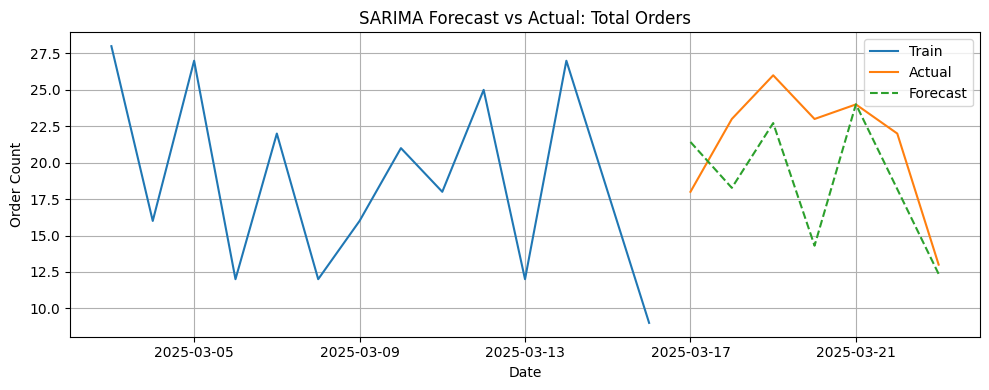

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
plt.title('SARIMA Forecast vs Actual: Total Orders')
plt.xlabel('Date')
plt.ylabel('Order Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

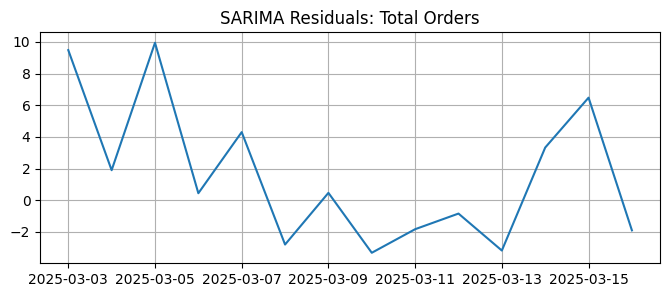

In [16]:
residuals = sarima_model.resid()
plt.figure(figsize=(8,3))
plt.plot(residuals)
plt.title("SARIMA Residuals: Total Orders")
plt.grid(True)
plt.show()

## Forecast by total sales

In [17]:
df_sales = pd.read_csv('Dataset/daily_coffee_sales.csv')
df_sales.head(5)

,date,total_sales
0,2024-03-01,396.3
1,2024-03-02,228.1
2,2024-03-03,349.1
3,2024-03-04,135.2
4,2024-03-05,338.5


In [18]:
df_sales['date'] = pd.to_datetime(df_sales['date'])
df_sales = df_sales.sort_values('date')

In [48]:
df_sales_21 = df_sales.tail(21).set_index('date')
df_sales_30 = df_sales.tail(30).set_index('date')
df_sales_60 = df_sales.tail(60).set_index('date')

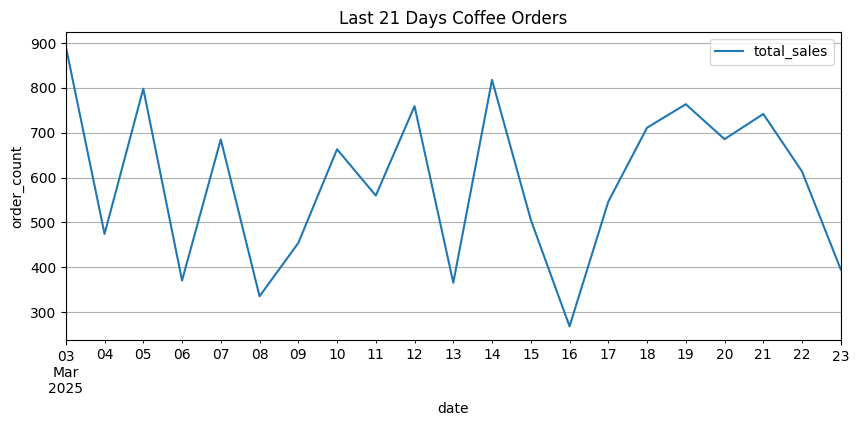

In [20]:
df_sales_21.plot(title='Last 21 Days Coffee Orders', figsize=(10, 4))
plt.ylabel('order_count')
plt.grid()
plt.show()

In [56]:
result = adfuller(df_sales_21.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

if result[1] <= 0.05:
    print("Series is stationary")
else:
    print("Series is not stationary")

ADF Statistic: -5.73458253138871
p-value: 6.482569220651985e-07
Critical Values:
	1%: -3.8092091249999998
	5%: -3.0216450000000004
	10%: -2.6507125
Series is stationary


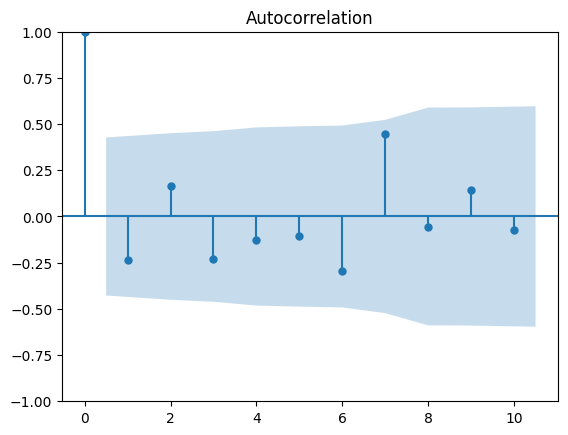

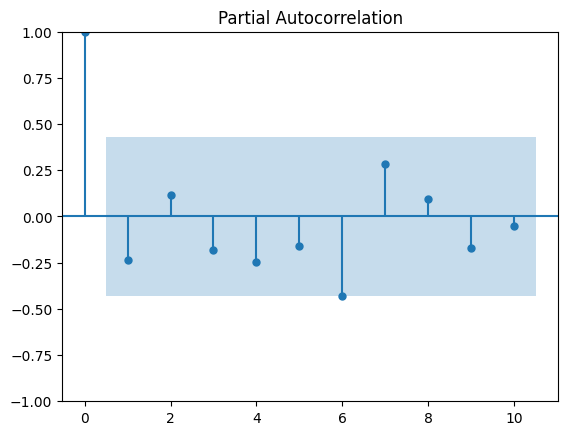

In [57]:
plot_acf(df_sales_21)
plot_pacf(df_sales_21)
plt.show()

<Axes: title={'center': '7-Day Rolling Mean'}, xlabel='date'>

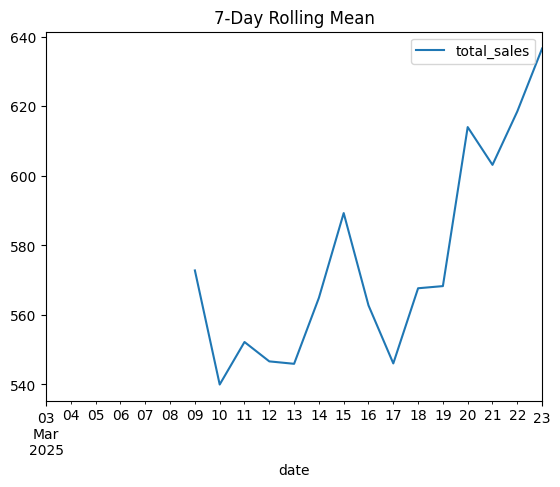

In [58]:
df_sales_21.rolling(window=7).mean().plot(title="7-Day Rolling Mean")

In [24]:
sarima_model = auto_arima(df_sales_21,
                          seasonal=True,
                          m=7,  # 7-day seasonality
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

print("Best model:", sarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=282.765, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=280.889, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=276.464, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=331.409, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=281.473, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=278.332, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=275.157, Time=0.05 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=274.068, Time=0.10 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(2,0,0)[7] intercept   : AIC=275.998, Time=0.12 sec
 ARIMA

In [25]:
n_days = 7  # forecast 7 days
forecast = sarima_model.predict(n_periods=n_days)

last_date = df_sales_21.index[-1]
forecast_index = [last_date + pd.Timedelta(days=i) for i in range(1, n_days+1)]
forecast_series = pd.Series(forecast, index=pd.to_datetime(forecast_index))

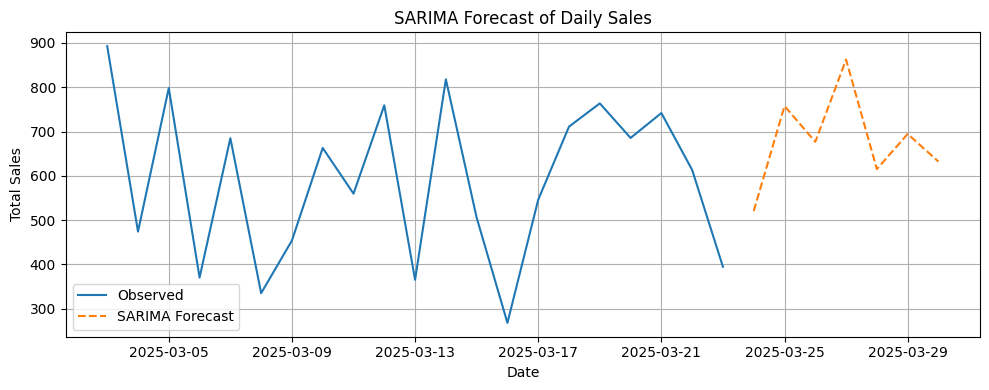

In [26]:
plt.figure(figsize=(10, 4))
plt.plot(df_sales_21.index, df_sales_21, label='Observed')
plt.plot(forecast_series.index, forecast_series, label='SARIMA Forecast', linestyle='--')
plt.title('SARIMA Forecast of Daily Sales')
plt.ylabel('Total Sales')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Evaluate

In [59]:
train = df_sales_21[:-7]
test = df_sales_21[-7:]
train = train['total_sales']
test = test['total_sales'] 

In [61]:
sarima_model = auto_arima(train,
                          seasonal=True,
                          m=7,
                          D=0,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=196.679, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=191.317, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=187.977, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=220.854, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=189.305, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=191.482, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=189.235, Time=0.10 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=188.486, Time=0.07 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=187.981, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=191.428, Time=0.06 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=190.609, Time=0.10 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,0,1)(1,0,0)[7] intercept   : AIC=inf, Time=0.09 se

In [62]:
forecast = sarima_model.predict(n_periods=7)
forecast = pd.Series(forecast, index=test.index)

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100

print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"MAPE = {mape:.2f}%")

MAE  = 196.64
RMSE = 229.32
MAPE = 30.77%


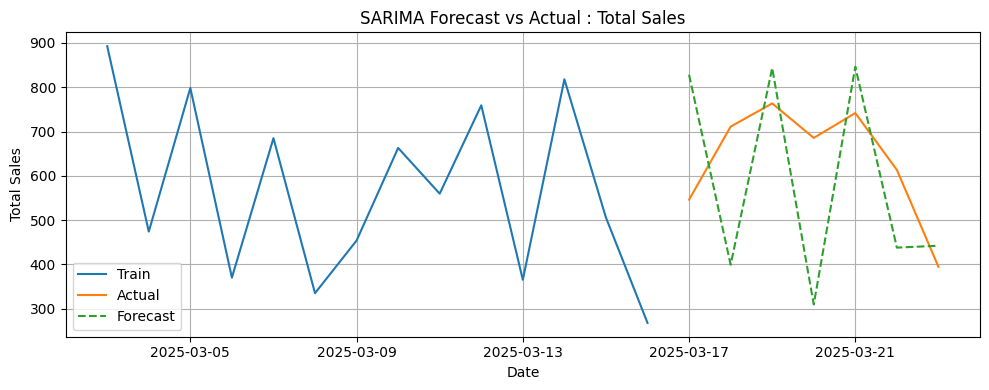

In [63]:
plt.figure(figsize=(10, 4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
plt.title('SARIMA Forecast vs Actual : Total Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

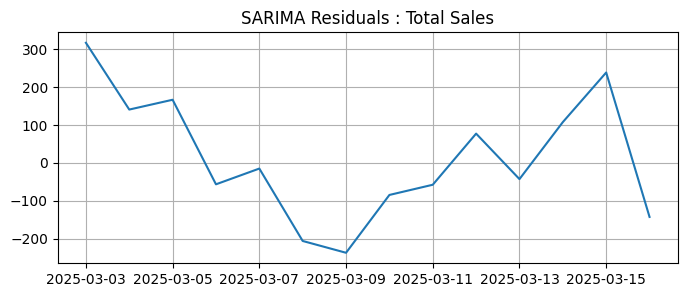

In [64]:
residuals = sarima_model.resid()
plt.figure(figsize=(8,3))
plt.plot(residuals)
plt.title("SARIMA Residuals : Total Sales")
plt.grid(True)
plt.show()